LCOE_låg är: 39210618.8121988
LCOE_medel är: 53827082.67683873
LCOE_hög är: 61848971.960192695
Summa kostnad i el 2023: 12039244.362725955
Original elförbrukning topptimmar:     Timme  Elförbrukning
0    1961        1693.00
1    2009        1693.00
2    1985        1641.00
3    2322        1627.00
4    2202        1614.00
5    2442        1611.00
6    2033        1602.00
7    2274        1596.00
8    2178        1594.00
9    2153        1593.00
10   2010        1586.00
11   2129        1580.00
12   2226        1576.00
13   1986        1571.00
14   2130        1570.00
15   2298        1567.00
16   2250        1563.00
17   2057        1561.00
18   8105        1555.75
19   2154        1555.00
20   2370        1554.00
21   1962        1553.00
22   2082        1553.00
23   2394        1552.00
24   8081        1541.25
25   2466        1537.00
26   2105        1534.00
27   2418        1530.00
28   2106        1529.00
29   2538        1526.00
Snitt originaltopptimmar: 1578.6

Genomsnittligt da

C:\Users\jakob\AppData\Local\Temp\ipykernel_21428\1573203302.py:52: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ABKEl["Tid"] = pd.date_range(start="2023-01-01 00:00", periods=len(ABKEl), freq="H")
C:\Users\jakob\AppData\Local\Temp\ipykernel_21428\1573203302.py:55: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  Spotpris["Tid"] = pd.date_range(start="2023-01-01 00:00", periods=len(Spotpris), freq="H")
C:\Users\jakob\AppData\Local\Temp\ipykernel_21428\1573203302.py:59: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_ABK = ABKEl["ABKEl"].resample("M").mean()
C:\Users\jakob\AppData\Local\Temp\ipykernel_21428\1573203302.py:60: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_E = Spotpris["Spotpris"].resample("M").mean()
C:\Users\jakob\AppData\Local\Temp\ipyk


Total besparing i elkostnad för sänka (inkl. moms, exkl. fast avgift): 3409095.72 kr
Justerad elkostnad simulering: 9003358.616788436
Besparing_låg efter 30 år: 51865953.56592676
Besparing_medel efter 30 år: 37249489.70128683
Besparing_hög efter 30 år: 29227600.417932868


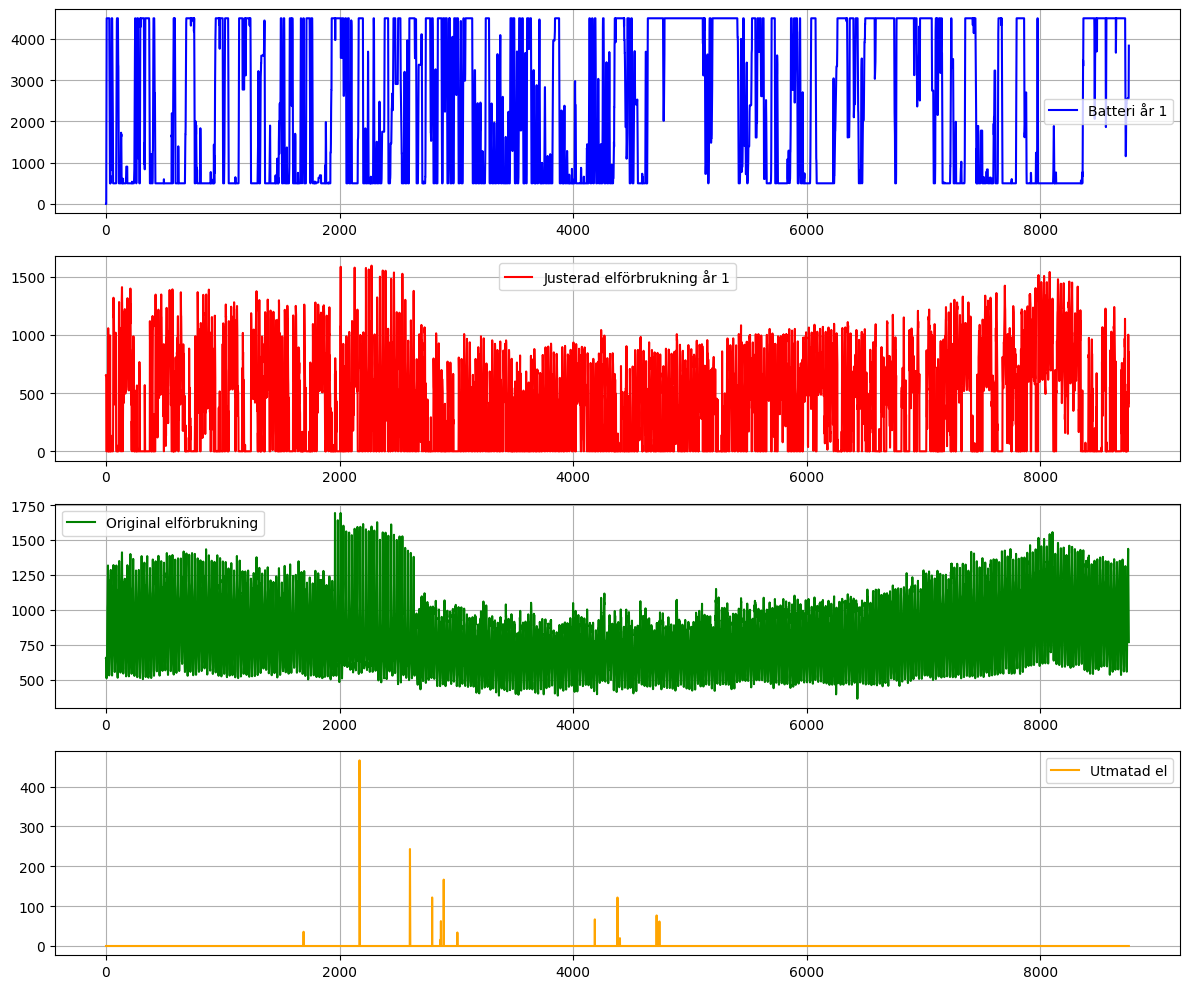

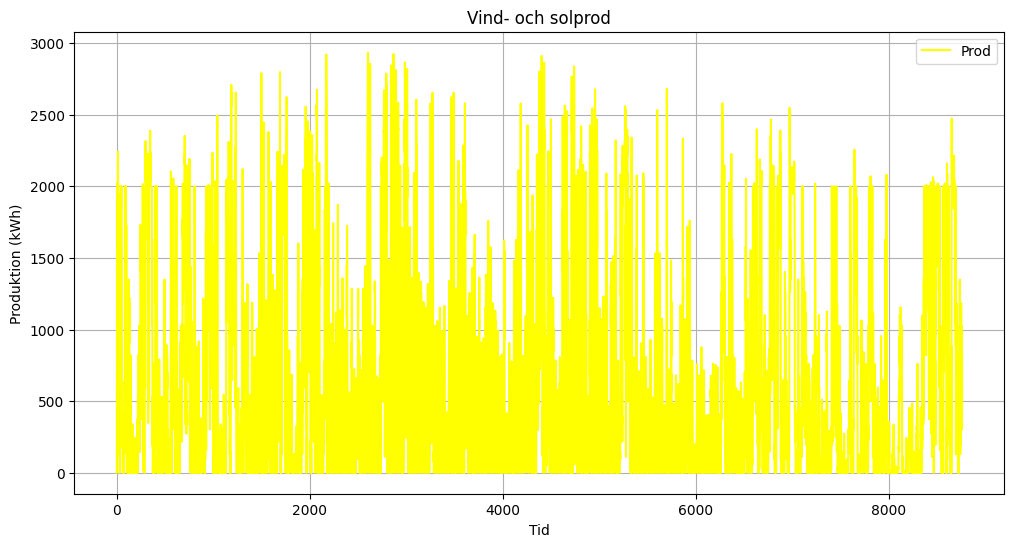

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Läs in Excel-filer
Solprod = pd.read_excel("SolprodABK.xlsx", header=None)
ABKEl = pd.read_excel("ABKEL.xlsx", names=["ABKEl"], header=None)
Spotpris = pd.read_excel("Spotpris.xlsx", names=["Spotpris"], header=None)  # Namnge kolumnen korrekt
Vindprod = pd.read_excel("Vindturbin.xlsx", header=None)
StarkaEl = pd.read_excel("Starka2023.xlsx", header=None)
KLTel = pd.read_excel("KLTelFörbr.xlsx", header=None)
Skånemej = pd.read_excel("Eldata-filerSÖDRA/SkånemejElförbr.xlsx", header= None)

Mejan = Skånemej.iloc[:, 0]

ABK = ABKEl.iloc[:, 0]
Starka = StarkaEl.iloc[:, 0]
KLT = KLTel.iloc[:, 0]
# Extrahera första kolumnen från respektive DataFrame
Vind = Vindprod.iloc[:, 0]
Sol = 0.2*Solprod.iloc[:, 0]  # SOL = 0.25, Sol+Vind = 0.2

Sänka = Starka + KLT + Mejan
Prod =  Sol + Vind

LCOE_sol_låg = 0.29 #kr/kWh
LCOE_sol_medel = 0.43
LCOE_sol_hög = 0.52

LCOE_vind_låg = 0.24
LCOE_vind_medel = 0.32
LCOE_vind_hög = 0.36

livslängd = 30


LCOE_låg = (Sol.sum()*LCOE_sol_låg + Vind.sum()*LCOE_vind_låg)*30
LCOE_medel = (Sol.sum()*LCOE_sol_medel + Vind.sum()*LCOE_vind_medel)*30
LCOE_hög = (Sol.sum()*LCOE_sol_hög + Vind.sum()*LCOE_vind_hög)*30

print("LCOE_låg är:", LCOE_låg)
print("LCOE_medel är:", LCOE_medel)
print("LCOE_hög är:", LCOE_hög)

Prod_list = Prod.tolist()

# Konvertera Spotpris till en lista för iteration
Spot_list = Spotpris["Spotpris"].tolist()
ABK_list = ABKEl["ABKEl"].tolist()

# Skapa tidsindex för ABKEl och Spotpris
ABKEl["Tid"] = pd.date_range(start="2023-01-01 00:00", periods=len(ABKEl), freq="H")
ABKEl.set_index("Tid", inplace=True)

Spotpris["Tid"] = pd.date_range(start="2023-01-01 00:00", periods=len(Spotpris), freq="H")
Spotpris.set_index("Tid", inplace=True)

# Resampla till månatligt genomsnitt
monthly_avg_ABK = ABKEl["ABKEl"].resample("M").mean()
monthly_avg_E = Spotpris["Spotpris"].resample("M").mean()

# Beräkna överföringsavgift per månad
Spotpris["E"] = 4.004 + 0.0613 * Spotpris["Spotpris"]
monthly_avg_E = Spotpris["E"].resample("M").mean()

# Beräkna summa överföringsavgift för hela året
summaÖverfAvgift = (monthly_avg_E * monthly_avg_ABK).sum()
fastAbbKostnad = 795180.4
summaElnätskostnadKR = (summaÖverfAvgift / 100) + fastAbbKostnad

Spot_array = np.array(Spot_list)
ABK_array = np.array(ABK_list)

elhandelskostnad = (Spot_array * ABK_array).sum() / 100
energiskatt = (43.9 * ABK_array).sum() / 100

summaElKostnad = (summaElnätskostnadKR + elhandelskostnad + energiskatt) * 1.25

print("Summa kostnad i el 2023:", summaElKostnad)

# Ta fram elförbrukning (första kolumnen) som en Pandas Series
elförbrukning = pd.Series(ABK)

# Sortera elförbrukningen i fallande ordning och hämta de 30 högsta värdena
top_30_hours = elförbrukning.sort_values(ascending=False).head(30)

# Skapa en DataFrame med radnummer (index) och värde (elförbrukning)
top_30_with_index = top_30_hours.reset_index()

# Byt namn på kolumnerna för bättre läsbarhet
top_30_with_index.columns = ['Timme', 'Elförbrukning']

# Skriv ut de 30 timmarna med högst elförbrukning och radnummer
print("Original elförbrukning topptimmar: " + top_30_with_index.to_string())
print("Snitt originaltopptimmar: " + str(top_30_hours.mean()))



# ----------------------- YEAR 1 SIMULATION -----------------------
batteriKapacitet = 0.0  # Start with an empty battery
batteriMaxKapacitet = 5000  # Max battery capacity in kWh
min_battery_level = batteriMaxKapacitet*0.1
max_battery_level = batteriMaxKapacitet * 0.9
maxFrånBatteri = 1500



justeradElförbrukning = []  # Adjusted electricity consumption for Year 1
battery_values = []  # Battery energy over time
original_consumption = ABKEl["ABKEl"].tolist()
# Convert ABK to list for original consumption

köptaTimmar = []  # Lista för köpta spotpriser och tid
utmatning = []

sänka_tid = []
sänka_konsumtion = []
sänka_spotpris = []


for tid, prod, abk, spot, sänka in zip(Spotpris.index, Prod, ABK, Spot_list, Sänka):  
    diff = abk - prod  # Skillnad mellan förbrukning och solproduktion


    if diff <= 0:
        batteriKapacitet = min(batteriKapacitet - diff, max_battery_level)
        justeradElförbrukning.append(0)

    # Maxpotential till sänka från överskott (det som inte går till batteri)
        överskott = -diff  # diff är negativ, så -diff är produktion över förbrukning
        möjlig_utmatning = max(0, överskott - (max_battery_level - batteriKapacitet))

        till_sänka = min(sänka, möjlig_utmatning)
        till_nätet = max(0, möjlig_utmatning - till_sänka)

        utmatning.append(till_nätet)
        köptaTimmar.append((tid, 0))

        if till_sänka > 0:
            sänka_tid.append(tid)
            sänka_konsumtion.append(till_sänka)
            sänka_spotpris.append(Spotpris.loc[tid, "Spotpris"])

    else:
        if spot <= 30 and prod > 0:
            möjligLagring = max_battery_level - batteriKapacitet
            lagrat = min(prod, möjligLagring)
            överskott = max(0, prod - lagrat)
            batteriKapacitet += lagrat
            
            köpt_el = max(0, abk - överskott)

            justeradElförbrukning.append(köpt_el)
            köptaTimmar.append((tid, spot if köpt_el > 0 else 0))
            utmatning.append(0)

        elif 30 < spot < 70 and prod > 0:
            justeradElförbrukning.append(diff)
            köptaTimmar.append((tid, spot))
            utmatning.append(0)
        elif spot >= 70:
            energiFrånBatteri = max(0, min(batteriKapacitet, diff, maxFrånBatteri, batteriKapacitet-min_battery_level))
            batteriKapacitet -= energiFrånBatteri
            köpt_el = max(0, diff - energiFrånBatteri)
            justeradElförbrukning.append(köpt_el)  
            köptaTimmar.append((tid, spot if köpt_el > 0 else 0))
            utmatning.append(0)
        else:
            justeradElförbrukning.append(abk)  
            köptaTimmar.append((tid, spot))
            utmatning.append(0)


    battery_values.append(batteriKapacitet)


# Skapa DataFrame med tidsindex och batterinivå
battery_df = pd.DataFrame({
    "Tid": Spotpris.index[:len(battery_values)],
    "Batteri": battery_values
})
battery_df.set_index("Tid", inplace=True)

# Räkna ut daglig max och min batterinivå
daily_max = battery_df["Batteri"].resample("D").max()
daily_min = battery_df["Batteri"].resample("D").min()

# Räkna ut DoD per dag i procent
daily_DoD = (daily_max - daily_min) / batteriMaxKapacitet * 100

# Räkna ut genomsnittligt dagligt DoD
average_DoD = daily_DoD.mean()

print(f"\nGenomsnittligt dagligt Depth of Discharge (DoD) under året: {average_DoD:.2f}%")

# Konvertera elförbrukning till en NumPy-array
elförbrukning_array = np.array(justeradElförbrukning)

# Hitta de 30 högsta värdena i elförbrukning
top_30_indices = np.argsort(elförbrukning_array)[-30:]  # Index för de 30 största värdena

# Hämta de faktiska tidsstämplarna från Spotpris.index
top_30_times = Spotpris.index[top_30_indices]

# Hämta de 30 största elförbrukningsvärdena
top_30_values = elförbrukning_array[top_30_indices]

# Sortera topp 30 i fallande ordning och behåll index
sorted_pairs = sorted(zip(top_30_values, top_30_times), reverse=True)

values_only = [value for value, _ in sorted_pairs]
mean_value = sum(values_only) / len(values_only)
print(f"Snitt = {mean_value:.2f}")

# Skriv ut de 30 högsta värdena tillsammans med originaltimmarna
print("De 30 högsta elförbrukningsvärdena och deras timmar i Excel-filen:")

for i, (value, original_time) in enumerate(sorted_pairs):
    excel_rad = i + 8  # +8 för rubrikrad och 1-baserade index, och +1 för att börja från 1
    print(f"{i+1}. Timme {original_time}  - Förbrukning: {value} (Excel rad: {excel_rad})")


sänka_df = pd.DataFrame({
    "Tid": sänka_tid,
    "El": sänka_konsumtion,
    "Spotpris": sänka_spotpris
})
sänka_df.set_index("Tid", inplace=True)

sänka_df["Elhandelskostnad"] = sänka_df["El"] * sänka_df["Spotpris"] / 100
total_elhandelskostnad_sänka = sänka_df["Elhandelskostnad"].sum()

sänka_df["E"] = 2.23 + 0.0583 * sänka_df["Spotpris"]

monthly_avg_E_sänka = sänka_df["E"].resample("M").mean()

monthly_total_elförbrukning_sänka= sänka_df["El"].resample("M").sum()

summaJusteradÖverf_sänka = ((monthly_avg_E_sänka * monthly_total_elförbrukning_sänka).sum())/100

monthly_max_effekt = sänka_df["El"].resample("M").max()  # Högsta värde per månad

# Effektavgift (per kW)
effektavgift = 57.04  # kr/kW

# Beräkna effektkostnad per månad
effektkostnad_per_månad = monthly_max_effekt * effektavgift  # Kostnad per månad

# Summera effektkostnaden för hela året
total_effektkostnad_sänka = effektkostnad_per_månad.sum()

energiskatt_sänka = sänka_df["El"].sum() * 43.9 / 100

summa_sänka = (
    total_elhandelskostnad_sänka +
    summaJusteradÖverf_sänka +
    total_effektkostnad_sänka +
    energiskatt_sänka
)

summa_sänka_med_moms = summa_sänka * 1.25

print(f"\nTotal besparing i elkostnad för sänka (inkl. moms, exkl. fast avgift): {summa_sänka_med_moms:.2f} kr")


# Skapa DataFrame för de köpta timmarna
köptaTimmar_df = pd.DataFrame(köptaTimmar, columns=["Tid", "Spotpris"])
köptaTimmar_df.set_index("Tid", inplace=True)

# Beräkna överföringsavgiften per timme för köpta timmar
köptaTimmar_df["E"] = 4.004 + 0.0613 * köptaTimmar_df["Spotpris"]

# Beräkna månatligt medelvärde för överföringsavgiften och elförbrukningen
monthly_avg_E_köpt = köptaTimmar_df["E"].resample("M").mean()

# Skapa DataFrame för den uppdaterade elförbrukningen
elförbrukning_df = pd.DataFrame({"Tid": Spotpris.index, "elförbrukning": justeradElförbrukning})
elförbrukning_df.set_index("Tid", inplace=True)

# Beräkna månatligt medelvärde av den uppdaterade elförbrukningen
monthly_total_elförbrukning = elförbrukning_df["elförbrukning"].resample("M").sum()

# Beräkna justerad överföringsavgift
summaJusteradÖverf = (monthly_avg_E_köpt * monthly_total_elförbrukning).sum()

# Omvandla till kronor och addera den fasta abonnemangskostnaden
summaJusteradÖverfKR = (summaJusteradÖverf / 100) + fastAbbKostnad

# Filtrera elförbrukning endast för de köpta timmarna
elförbrukning_köpt = elförbrukning_df.loc[köptaTimmar_df.index]

# Beräkna elhandelskostnaden: Spotpris * elförbrukning
elhandelskostnad_köpt = (köptaTimmar_df["Spotpris"] * elförbrukning_köpt["elförbrukning"]).sum() / 100

# Beräkna den justerade energiskatten
total_elförbrukning = sum(elförbrukning)
JusteradEnergiskatt = (total_elförbrukning * 43.9) / 100

# Beräkna den justerade elkostnaden
summaJusteradElkostnad = 1.25 * (JusteradEnergiskatt + elhandelskostnad_köpt + summaJusteradÖverfKR)

print("Justerad elkostnad simulering:", summaJusteradElkostnad)

print("Besparing_låg efter 30 år:", (summaElKostnad - summaJusteradElkostnad)*30 - LCOE_låg)
print("Besparing_medel efter 30 år:", (summaElKostnad - summaJusteradElkostnad)*30 - LCOE_medel)
print("Besparing_hög efter 30 år:", (summaElKostnad - summaJusteradElkostnad)*30 - LCOE_hög)
# ----------------------- PLOTTING RESULTS -----------------------
fig, ax = plt.subplots(4, 1, figsize=(12, 10))

ax[0].plot(battery_values, label='Batteri år 1', color='blue')
ax[1].plot(justeradElförbrukning, label='Justerad elförbrukning år 1', color='red')
ax[2].plot(original_consumption, label='Original elförbrukning', color='green')
ax[3].plot(utmatning, label='Utmatad el', color='orange')

for a in ax:
    a.legend()
    a.grid(True)

plt.tight_layout()
plt.show()

# Skapa en figur och plotta
plt.figure(figsize=(12, 6))
plt.plot(Prod_list, label="Prod", color="yellow")

plt.xlabel("Tid")
plt.ylabel("Produktion (kWh)")
plt.title("Vind- och solprod")
plt.legend()
plt.grid(True)

# Visa grafen
plt.show()

